# 1. Imports

In [1]:
import time
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer
#
import xgboost as xgb
#
from blending import BlendedRegressor
#
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
# plot plots inline
%matplotlib inline  

# 2. Data cleaning

## 2.1 Dataset IO

In [4]:
# Read training set into memory
# trn = pd.read_csv('../data/train.csv')
# trn_10 = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is index
trn = pd.read_csv('../data/train_1.csv', index_col=0)

# reading the MP values for training data
MP_train = pd.read_csv('../data/MP_train.csv')

## 2.2 Cleaning

In [5]:
t = time.time()  # tic
## filter out observations with non-valid 'Ref'
# trn_1_withRef = trn_1[trn_1['Ref'].notnull()]
# trn_10_withRef = trn_10[trn_10['Ref'].notnull()]
trn_withRef = trn[trn['Ref'].notnull()]
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc
## dimension checking
# print trn_1.shape, trn_1_withRef.shape, trn_1_withRef['Id'].nunique(), trn_1['Id'].nunique()
# print trn_10.shape, trn_10_withRef.shape, trn_10_withRef['Id'].nunique(), trn_10['Id'].nunique()
print trn.shape, trn_withRef.shape, trn_withRef['Id'].nunique(), trn['Id'].nunique()

Time elapsed: 0.0329 secs
(137652, 24) (63930, 24) 60870 130076


## 2.3 Combine observation

In [6]:
# Combine observations by 'Id'
t = time.time()
# trn_withRef_comb = trn_withRef.groupby('Id').agg(np.mean)
trn_withRef_comb = trn_withRef.groupby('Id').agg(['mean','std','median','count','min', 'max'])
trn_withRef_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_withRef_comb.columns.values)]
trn_withRef_comb = trn_withRef_comb.drop(['Expected_count', 'Expected_median', 'Expected_std', 'Expected_min','Expected_max'], axis =1)
# trn_withRef_comb.columns = ['_'.join(tup) for tup in trn_withRef_comb.columns.values]
print time.time()-t

0.59058880806


In [ ]:
trn_withRef_comb.columns

In [ ]:
# MP_09 = MP_train.loc[MP_train['Id'].isin(trn_withRef_comb.index)]
# MP_09.set_index('Id', inplace=True)

In [ ]:
# truth = trn_withRef_comb['Expected_mean']
# mp = MP_09['Expected']
# diff = truth-mp
# log_diff = np.log10(100+diff)
# print truth.min(), truth.median(), truth.max()
# print mp.min(), mp.median(), mp.max()
# print diff.min(), diff.median(), diff.max()
# print np.percentile(diff, [1, 10, 50, 90, 95])
# tmp = tmp + np.min(tmp)
# print tmp.min(), tmp.median(), tmp.max()
# tmp = tmp/np.median(tmp)
# diff.hist(bins=100)
# plt.xlim([-100, 100])
# np.sum(tmp.isnull())

## 2.4 Form feature X and target y

In [7]:
# Extract matrix-form data from pandas df
X = trn_withRef_comb.loc[:, 'minutes_past_mean':'Kdp_5x5_90th_max']  # NOTE: used range slicing on column
# y = np.log10(trn_withRef_comb['Expected'].values)  # y = log(Truth)
y = np.log10(1+trn_withRef_comb['Expected_mean'])  # y = log(1+Truth)
# y = (trn_withRef_comb['Expected']-MP_09['Expected']).values  # y = Truth-MP
# y = np.log10(1+trn_withRef_comb['Expected']-MP_09['Expected']).values  # y = log(100+Truth-MP)

In [8]:
X.columns

Index([u'minutes_past_mean', u'minutes_past_std', u'minutes_past_median',
       u'minutes_past_count', u'minutes_past_min', u'minutes_past_max',
       u'radardist_km_mean', u'radardist_km_std', u'radardist_km_median',
       u'radardist_km_count',
       ...
       u'Kdp_5x5_50th_median', u'Kdp_5x5_50th_count', u'Kdp_5x5_50th_min',
       u'Kdp_5x5_50th_max', u'Kdp_5x5_90th_mean', u'Kdp_5x5_90th_std',
       u'Kdp_5x5_90th_median', u'Kdp_5x5_90th_count', u'Kdp_5x5_90th_min',
       u'Kdp_5x5_90th_max'],
      dtype='object', length=132)

In [9]:
def MAE_logy(ground_truth, predictions):
    """Custom scoring function for log(y) or log(1+y)
       NOTE: please change this if you use another non-linearity on y
    """
    return np.float64(np.mean(np.abs(10**ground_truth - 10**predictions)))
def MAE(ground_truth, predictions):
    """Standard MAE
    """
    return np.float64(np.mean(np.abs(ground_truth - predictions)))

# 3 ML and Validation

## 3.1 Constuct pipeline

In [10]:
imp = Imputer(strategy='mean')  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
base1 = RandomForestRegressor(n_estimators=100, max_features='sqrt', max_depth=5, n_jobs=4)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
base2 = LinearRegression()
base3 = Ridge()
blender = LinearRegression()
blended = BlendedRegressor(base_models=(base1, base2, base3), blending_model=blender, blending_split=10)
pip = Pipeline([('imp',imp), ('ss',ss), ('clf',base2)])  # a Pipeline wrapper to chain'em up

## 3.2 Cross validation

### 3.2.1 Initialization

In [11]:
scorer = make_scorer(MAE_logy, greater_is_better=True)  # define scoring metric

### 3.2.2A: Single param value cv

In [ ]:
# This is for getting a basic idea of how long it takes to run a single parameter

In [12]:
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=1)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.3s finished


In [45]:
# Scores:
# Filter-out null ref, !!!log(Truth)!!!, impute with mean, (0,1) standardization, RF with 10 trees, 'sqrt' features, depth=5
print np.mean(scores), np.std(scores)

23.2716100202 1.57705091824


In [128]:
# Scores:
# [mean], Filter-out null ref, !!!log(1+Truth)!!!, impute with mean, (0,1) standardization, RF with 10 trees, 'sqrt' features, depth=5
print np.mean(scores), np.std(scores)

23.3509680762 1.57723658976


In [172]:
# Scores:
# [mean, med, std, cnt], all feature, include ref, !!!log(1+Truth)!!!, impute with mean, (0,1) standardization, RF with 10 trees, 'sqrt' features, depth=5
print np.mean(scores), np.std(scores)

132.170990758 7.72976027985


In [157]:
# Scores:
# [mean, med, std, min, max, cnt], all feature
# Filter-out null ref, !!!log(1+Truth)!!!, impute with mean, (0,1) standardization
# RF with 10 trees, 'sqrt' features, depth=5
print np.mean(scores), np.std(scores)

23.2697228078 1.5791936134


In [53]:
# Scores:
# Filter-out null ref, !!!Truth-MP!!!, impute with mean, (0,1) standardization, RF with 10 trees, 'sqrt' features, depth=5
print np.mean(scores), np.std(scores)

40.1995830031 1.57656296034


In [61]:
# Scores:
# Filter-out null ref, !!!log(100+Truth-MP)!!!, impute with mean, (0,1) standardization, RF with 10 trees, 'sqrt' features, depth=5
print np.mean(scores), np.std(scores)

26.1906870356 1.55649221847


In [148]:
# Scores:
# [mean, med, std, cnt], all feature
# Filter-out null ref, !!!log(1+Truth)!!!, impute with mean, (0,1) standardization
# RF with 10 trees, 'sqrt' features, depth=5
print np.mean(scores), np.std(scores)

23.3129628677 1.57943826265


In [10]:
# Scores:
# [mean, med, std, cnt], all feature, 
# Filter-out null ref, log(1+Truth), impute with mean, (0,1) standardization, 
# Blending: base: [RF with 10 tree, 'sqrt' features, depth=5], [linear regression]; blender: linear regression
print np.mean(scores), np.std(scores)

23.2223155559 1.58094899068


In [21]:
# Scores:
# [mean, med, std, cnt], all feature, 
# Filter-out null ref, log(1+Truth), impute with mean, (0,1) standardization, 
# Blending: base: [RF with 10 tree, 'sqrt' features, depth=5], [linear regression], [ridge]; blender: linear regression
print np.mean(scores), np.std(scores)

23.2210455962 1.58214249794


In [40]:
# Scores:
# [mean, med, std, cnt], all feature, 
# Filter-out null ref, log(1+Truth), impute with mean, (0,1) standardization, 
# Blending: base: [RF with 100 tree, 'sqrt' features, depth=5], [linear regression], [ridge]; blender: linear regression
print np.mean(scores), np.std(scores)

25.4251322521 1.63643231318


In [26]:
# Scores:
# [mean, med, std, cnt], all feature, 
# Filter-out null ref, log(1+Truth), impute with mean, (0,1) standardization, 
# Blending: base: [RF with 10 tree, 'sqrt' features, depth=5], [linear regression], [ridge]; blender: DecisionTreeRegressor()
print np.mean(scores), np.std(scores)

38.092708538 1.74175693759


In [32]:
# Scores:
# [mean, med, std, cnt], all feature, 
# Filter-out null ref, log(1+Truth), impute with mean, (0,1) standardization, 
# Blending: base: [RF with 10 tree, 'sqrt' features, depth=5], [linear regression], [ridge]; blender:  RandomForestRegressor(n_estimators=10, max_features='sqrt', max_depth=2)
print np.mean(scores), np.std(scores)

23.2445810224 1.58433463038


In [38]:
# Scores:
# [mean, med, std, cnt], all feature, 
# Filter-out null ref, log(1+Truth), impute with mean, (0,1) standardization, 
# Blending: base: [RF with 10 tree, 'sqrt' features, depth=5], [linear regression], [ridge]; blender:  KNN()
print np.mean(scores), np.std(scores)

25.4272316965 1.53517827948


### 3.2.2B: Validation curve on list of single param

In [130]:
# param_name, param_range='clf__n_estimators', [2**i for i in range(0, 8)]
param_name, param_range= 'clf__max_depth', range(1, 20, 2)
train_scores, test_scores= validation_curve(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=2, 
                          param_name=param_name, param_range=param_range, verbose=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  4.0min finished


Below: Filter-out null-ref samples, log(y), impute with mean, (0,1) standardization, RF with 10 trees, 'sqrt' features, max_depth=range(1, 20, 2)

In [131]:
print train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

[ 23.48850106  23.40157289  23.35608426  23.32141901  23.24709279
  23.03045067  22.62036214  21.74243459  20.60463995  19.04659527] [ 0.17045127  0.17846828  0.17614809  0.17518025  0.18058755  0.18559333
  0.1714176   0.1820058   0.25176128  0.30703489] [ 23.48714631  23.40407627  23.35831802  23.3368696   23.32463006
  23.31026567  23.36757853  23.38903279  23.45324982  23.63929665] [ 1.5792973   1.57219923  1.57508209  1.57773449  1.57435587  1.56007204
  1.55307983  1.5966486   1.58027541  1.61247645]


/home/jingchu/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


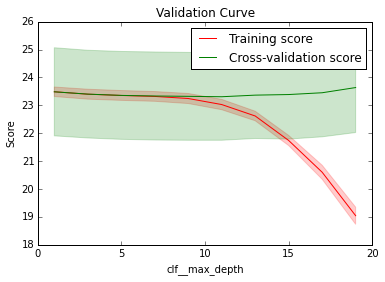

In [132]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()